In [1]:
import os
os.chdir('../../')

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import regression_data
from models import gaussian_mlp,mlp
from utilities import plot,fits,predict,gmm
from flax import linen as nn

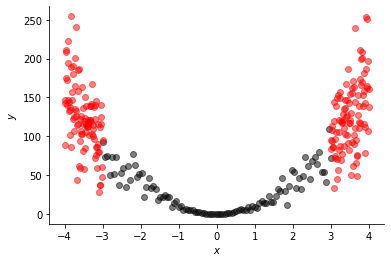

In [3]:
X,Y,x_test_1,y_test_1,x_test_2,y_test_2 = regression_data.data_set(n_points=100, poly=True,hetero=True)
plot.plot_actualdata(X,Y,x_test_1,y_test_1,x_test_2,y_test_2)

In [4]:
auxs = {
    "X" : X,
    "y" : Y,
    "deterministic": True,
}
X_sorted  = jnp.sort(X[:,0]).reshape(100,1)
Y_sorted  = jnp.sort(Y)
x_stack =jnp.concatenate([x_test_1,X_sorted,x_test_2],axis=0)
y_stack = jnp.concatenate([y_test_1,Y,y_test_2],axis=0)

## MLP

In [5]:
model = mlp.mlp([128,32,1],[nn.relu,nn.relu],[0,0])

In [6]:
model.tabulate(jax.random.PRNGKey(1), X, deterministic=True)

                           mlp Summary                           
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ outputs               ┃ params                  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs      │ - float32[100,1]      │                         │
│             │ - deterministic: True │                         │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 0_Dense     │ float32[100,128]      │ bias: float32[128]      │
│             │                       │ kernel: float32[1,128]  │
│             │                       │                         │
│             │                       │ 256 (1.0 KB)            │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 0_Dropout_0 │ float32[100,128]      │                         │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 1_Dense     │ float32[100,32]       │ bias: float32[32]       │
│             │                       │ kernel: float32[128,32] │
│             │                       │                         │
│             │                       │ 4,128 (16.5 KB)         │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 1_Dropout_0 │ float32[100,32]       │                         │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 2_Dense     │ float32[100,1]        │ bias: float32[1]        │
│             │                       │ kernel: float32[32,1]   │
│             │                       │                         │
│             │                       │ 33 (132 B)              │
├─────────────┼───────────────────────┼─────────────────────────┤
│ mlp         │ float32[100,1]        │                         │
├─────────────┼───────────────────────┼─────────────────────────┤
│             │                 Total │ 4,417 (17.7 KB)         │
└─────────────┴───────────────────────┴─────────────────────────┘
                                                                 
                Total Parameters: 4,417 (17.7 KB)                

'\n\n'

### Single MLP

In [7]:
seed=11
params = model.init(jax.random.PRNGKey(seed), X, deterministic = True)
params, loss =  fits.fit(model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)


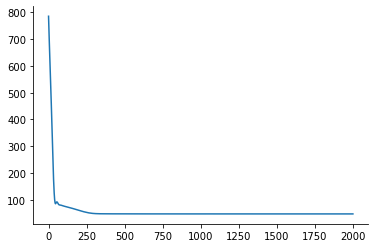

In [8]:
plt.plot(jnp.arange(0,2000,1),loss)
sns.despine()

In [9]:
y_hat = model.apply(params,x_stack,deterministic=True).reshape(300)
# y_hat 

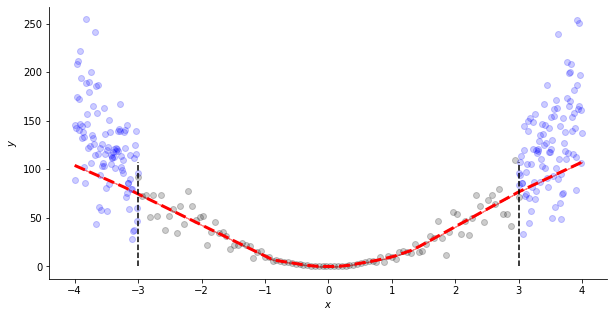

In [10]:

plot.plot_prediction(X,Y,x_stack,y_stack,y_hat,jnp.zeros(shape=y_hat.shape))

### Deep Ensemble Single MLP

In [11]:
params_list = []
losses_list = []
for i in range(5):
    params = model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fits.fit(model, params, auxs, learning_rate=0.003, epochs=2000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)

In [12]:
x_stack.shape

(300, 1)

In [13]:
y_hat_list = []
for i in range(5):
    y_hat =  model.apply(params_list[i], x_stack,deterministic=True)
    y_hat_list.append(y_hat)

In [14]:
jnp.array(y_hat_list).shape

(5, 300, 1)

In [15]:
mean  = jnp.array(y_hat_list).mean(axis=0).reshape(300)
sigma = jnp.array(y_hat_list).std(axis=0).reshape(300)

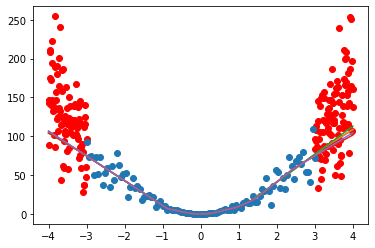

In [16]:
plt.scatter(x_test_1,y_test_1,color='red')
plt.scatter(x_test_2,y_test_2,color='red')
plt.scatter(X,Y)
for i in range(5):
    plt.plot(x_stack,y_hat_list[i])

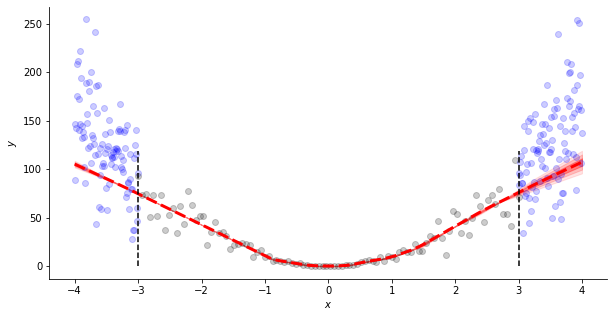

In [17]:
plot.plot_prediction(X,Y,x_stack,y_stack,mean,sigma)

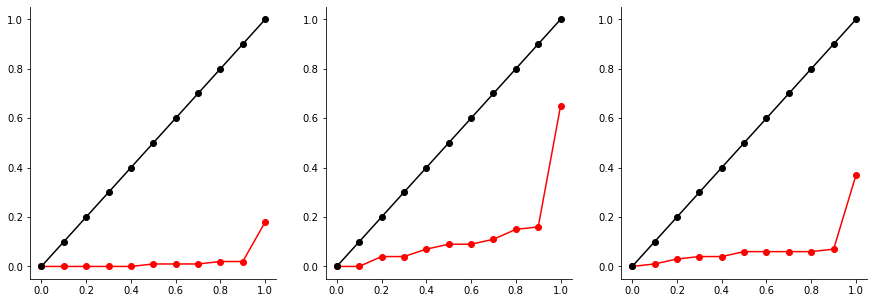

In [18]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
df,df2 = plot.calibration_regression(mean[:100],sigma[:100],y_test_1,ax1)
df = plot.calibration_regression(mean[100:200],sigma[100:200],Y,ax2)
df,_ = plot.calibration_regression(mean[200:],sigma[200:],y_test_2,ax3)

## Gaussian MLP

In [19]:
model = gaussian_mlp.gmlp( features=[128,32], activations=[nn.relu, nn.relu],dropout_rate=[0,0])

In [20]:
model.tabulate(jax.random.PRNGKey(1), X, deterministic=True)

                          gmlp Summary                           
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ path        ┃ outputs               ┃ params                  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Inputs      │ - float32[100,1]      │                         │
│             │ - deterministic: True │                         │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 0_Dense     │ float32[100,128]      │ bias: float32[128]      │
│             │                       │ kernel: float32[1,128]  │
│             │                       │                         │
│             │                       │ 256 (1.0 KB)            │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 0_Dropout_0 │ float32[100,128]      │                         │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 1_Dense     │ float32[100,32]       │ bias: float32[32]       │
│             │                       │ kernel: float32[128,32] │
│             │                       │                         │
│             │                       │ 4,128 (16.5 KB)         │
├─────────────┼───────────────────────┼─────────────────────────┤
│ 1_Dropout_0 │ float32[100,32]       │                         │
├─────────────┼───────────────────────┼─────────────────────────┤
│ Gaussian    │ float32[100,2]        │ bias: float32[2]        │
│             │                       │ kernel: float32[32,2]   │
│             │                       │                         │
│             │                       │ 66 (264 B)              │
├─────────────┼───────────────────────┼─────────────────────────┤
│ gmlp        │ - float32[100]        │                         │
│             │ - float32[100]        │                         │
├─────────────┼───────────────────────┼─────────────────────────┤
│             │                 Total │ 4,450 (17.8 KB)         │
└─────────────┴───────────────────────┴─────────────────────────┘
                                                                 
                Total Parameters: 4,450 (17.8 KB)                

'\n\n'

### Single Gaussian MLP

In [40]:
seed=11
params = model.init(jax.random.PRNGKey(seed), X, deterministic = True)
params, loss =  fits.fit(model, params, auxs, learning_rate=0.03, epochs=1000, verbose=False)


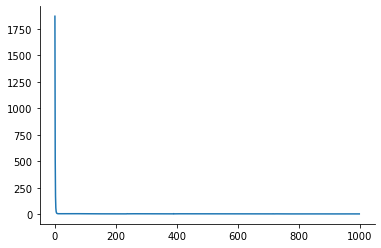

In [42]:
plt.plot(jnp.arange(0,1000,1),loss)
sns.despine()


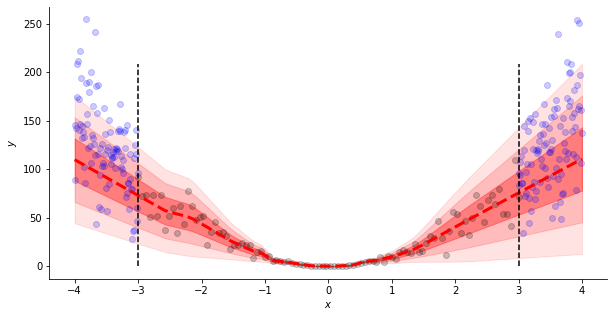

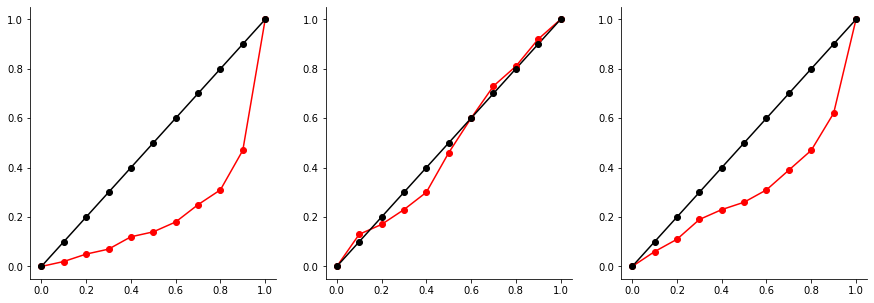

In [43]:
mean,sigma = model.apply(params,x_stack,deterministic=True)
plot.plot_prediction(X,Y,x_stack,y_stack,mean,sigma)
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
df,df2 = plot.calibration_regression(mean[:100],sigma[:100],y_test_1,ax1)
df = plot.calibration_regression(mean[100:200],sigma[100:200],Y,ax2)
df,_ = plot.calibration_regression(mean[200:],sigma[200:],y_test_2,ax3)


### Gaussian Deep Ensemble

In [34]:
params_list = []
losses_list = []

for i in range(5):
    params = model.init(jax.random.PRNGKey(i), auxs['X'], deterministic = True)
    params, loss =  fits.fit(model, params, auxs, learning_rate=0.03, epochs=1000, verbose=False)
    params_list.append(params)
    losses_list.append(loss)



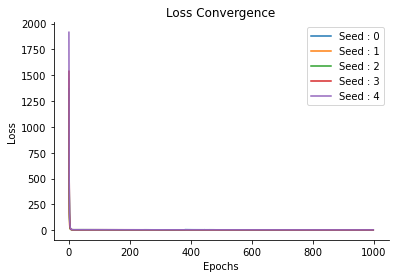

In [36]:
for i in range(5):
    plt.plot(jnp.arange(0,1000,1),losses_list[i],label=f'Seed : {i}')
plt.legend()
plt.title('Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
sns.despine()

In [37]:
means_list,sigmas_list = predict.predict(5,model,params_list,x_stack)
mean,sigma = gmm.gmm_mean_var(means_list,sigmas_list)


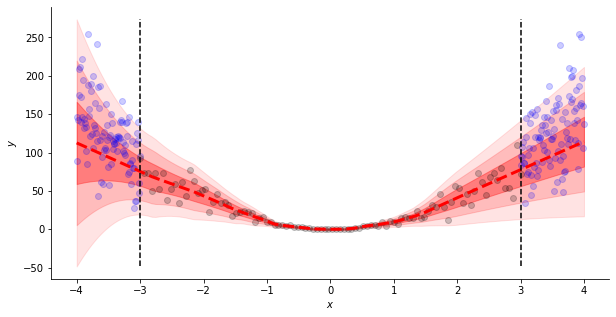

In [38]:
plot.plot_prediction(X,Y,x_stack,y_stack,mean,sigma)

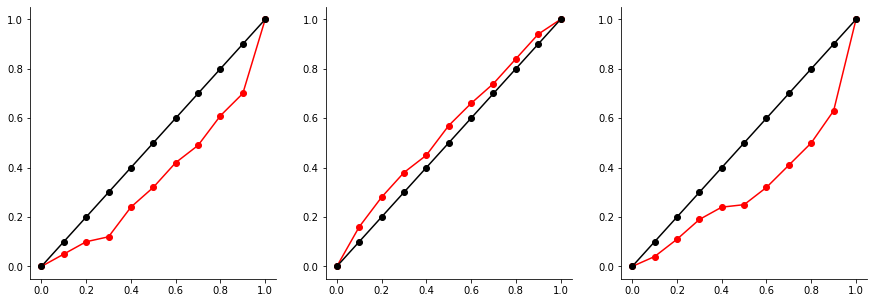

In [39]:
fig, (ax1, ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
df = plot.calibration_regression(mean[:100],sigma[:100],y_test_1,ax1)
df = plot.calibration_regression(mean[100:200],sigma[100:200],Y_sorted,ax2)
df = plot.calibration_regression(mean[200:],sigma[200:],y_test_2,ax3)
